<a href="https://colab.research.google.com/github/shreyamaurya029/AI-vs-Human-/blob/main/BERT_Finalipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files

# Check if GPU is available and set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
# Load the CSV file
df = pd.read_csv('/content/drive/MyDrive/traindataset (1).csv')

# Preprocess the data
MAX_LEN = 128
BATCH_SIZE = 16

# Drop columns that contain lists as strings or other non-numeric values
columns_to_drop = ['text_str']  # Replace with actual column names to drop if necessary
df = df.drop(columns=columns_to_drop)

class SentenceFeatureDataset(Dataset):
    def __init__(self, texts, features, labels, tokenizer, max_len):
        self.texts = texts
        self.features = features
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        feature = self.features[idx]
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True
        )

        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'features': torch.tensor(feature, dtype=torch.float32),
            'label': torch.tensor(label, dtype=torch.long)
        }

# Split the data
X_train, X_val, y_train, y_val = train_test_split(
    df.drop(columns=['Label']),
    df['Label'],
    test_size=0.1,
    random_state=42
)

# Separate features and text
train_texts = X_train['Text'].values
val_texts = X_val['Text'].values

# Ensure all features are numeric
train_features = X_train.drop(columns=['Text']).apply(pd.to_numeric, errors='coerce').values.astype(np.float32)
val_features = X_val.drop(columns=['Text']).apply(pd.to_numeric, errors='coerce').values.astype(np.float32)

# Handle any potential NaNs by filling with zero or any other strategy
train_features = np.nan_to_num(train_features)
val_features = np.nan_to_num(val_features)

# Convert labels to numpy arrays
y_train = y_train.values
y_val = y_val.values

# Initialize tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Create datasets and dataloaders
train_dataset = SentenceFeatureDataset(
    texts=train_texts,
    features=train_features,
    labels=y_train,
    tokenizer=tokenizer,
    max_len=MAX_LEN
)

val_dataset = SentenceFeatureDataset(
    texts=val_texts,
    features=val_features,
    labels=y_val,
    tokenizer=tokenizer,
    max_len=MAX_LEN
)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
class BertWithFeatures(nn.Module):
    def __init__(self, n_features):
        super(BertWithFeatures, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.feature_extractor = nn.Linear(n_features, 128)
        self.dropout = nn.Dropout(p=0.3)
        self.classifier = nn.Linear(self.bert.config.hidden_size + 128, 2)

    def forward(self, input_ids, attention_mask, features):
        bert_output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        bert_pooled_output = bert_output.pooler_output

        feature_output = self.feature_extractor(features)
        feature_output = nn.ReLU()(feature_output)

        combined_output = torch.cat((bert_pooled_output, feature_output), dim=1)
        combined_output = self.dropout(combined_output)
        logits = self.classifier(combined_output)

        return logits

# Initialize the model
n_features = train_features.shape[1]
model = BertWithFeatures(n_features)
model = model.to(device)


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [ ]:
# Training parameters
EPOCHS = 3
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)
loss_fn = nn.CrossEntropyLoss().to(device)

# Training function
def train_epoch(model, data_loader, loss_fn, optimizer, device, n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0

    for d in data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        features = d["features"].to(device)
        labels = d["label"].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            features=features
        )

        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, labels)

        correct_predictions += torch.sum(preds == labels)
        losses.append(loss.item())

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    return correct_predictions.double() / n_examples, np.mean(losses)

# Evaluation function
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()
    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            features = d["features"].to(device)
            labels = d["label"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                features=features
            )

            _, preds = torch.max(outputs, dim=1)
            loss = loss_fn(outputs, labels)

            correct_predictions += torch.sum(preds == labels)
            losses.append(loss.item())

    return correct_predictions.double() / n_examples, np.mean(losses)

# Training loop
for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)

    train_acc, train_loss = train_epoch(
        model,
        train_loader,
        loss_fn,
        optimizer,
        device,
        len(train_dataset)
    )

    print(f'Train loss {train_loss} accuracy {train_acc}')

    val_acc, val_loss = eval_model(
        model,
        val_loader,
        loss_fn,
        device,
        len(val_dataset)
    )

    print(f'Validation loss {val_loss} accuracy {val_acc}')
    print()

# Save the model
model_save_path = '/content/drive/MyDrive/BERT'
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

# Download the model file
files.download(model_save_path)


Epoch 1/3
----------
Train loss 0.10667229396021631 accuracy 0.9710674585046444
Validation loss 0.0653251341849579 accuracy 0.9853814527181362

Epoch 2/3
----------
Train loss 0.018799575745157778 accuracy 0.9946703213034871
Validation loss 0.014266233109379509 accuracy 0.9956601187756967

Epoch 3/3
----------
Train loss 0.010171128174249831 accuracy 0.996929089893914
Validation loss 0.08045819298548232 accuracy 0.9819552306989493

Model saved to /content/drive/MyDrive/BERT


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
model.load_state_dict(torch.load('/content/drive/MyDrive/BERT', map_location=device))


<All keys matched successfully>

In [ ]:
import torch
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

def get_predictions(model, data_loader):
    model = model.eval()

    sentences = []
    predictions = []
    prediction_probs = []
    real_values = []

    with torch.no_grad():
        for d in data_loader:
            texts = d["text"]
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            features = d["features"].to(device)
            labels = d["label"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                features=features
            )

            _, preds = torch.max(outputs, dim=1)

            sentences.extend(texts)
            predictions.extend(preds)
            prediction_probs.extend(outputs)
            real_values.extend(labels)

    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()
    return sentences, predictions, prediction_probs, real_values

# Get predictions
y_sentences, y_pred, y_pred_probs, y_test = get_predictions(model, val_loader)

# Convert to numpy arrays for metric calculations
y_pred = y_pred.numpy()
y_test = y_test.numpy()

# Calculate and print additional metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')

# Print classification report
print('Classification Report:')
print(classification_report(y_test, y_pred, target_names=['Human', 'AI']))


Accuracy: 0.98
Precision: 0.98
Recall: 0.98
F1 Score: 0.98
Classification Report:
              precision    recall  f1-score   support

       Human       1.00      0.96      0.98      2159
          AI       0.97      1.00      0.98      2219

    accuracy                           0.98      4378
   macro avg       0.98      0.98      0.98      4378
weighted avg       0.98      0.98      0.98      4378



In [ ]:
# Ensure model is in evaluation mode
model.eval()

def get_predictions_and_labels(model, data_loader):
    model = model.eval()

    texts = []
    predictions = []
    real_values = []
    probabilities = []

    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            features = d["features"].to(device)
            labels = d["label"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                features=features
            )

            _, preds = torch.max(outputs, dim=1)
            probs = torch.nn.functional.softmax(outputs, dim=1)

            texts.extend(d["text"])
            predictions.extend(preds)
            real_values.extend(labels)
            probabilities.extend(probs[:, 1])

    predictions = torch.stack(predictions).cpu()
    real_values = torch.stack(real_values).cpu()
    probabilities = torch.stack(probabilities).cpu()
    return texts, predictions, real_values, probabilities

y_texts, y_pred, y_true, y_probs = get_predictions_and_labels(model, val_loader)

# Calculate the AUC score
auc = roc_auc_score(y_true, y_probs)
print(f'AUC: {auc:.4f}')

# Get the ROC curve data
fpr, tpr, thresholds = roc_curve(y_true, y_probs)

# Plot the ROC curve
plt.figure()
plt.plot
plt.show()

AUC: 0.9992


<Figure size 640x480 with 0 Axes>

In [ ]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader

# Load the test dataset
test_df = pd.read_csv('/content/drive/MyDrive/testdataset (1).csv')  # Update the path to your test dataset file

# Preprocess the test data
test_texts = test_df['Text'].values
test_features = test_df.drop(columns=['Text', 'text_str', 'Label']).apply(pd.to_numeric, errors='coerce').values.astype(np.float32)
test_features = np.nan_to_num(test_features)  # Handle any potential NaNs by filling with zero or any other strategy
test_labels = test_df['Label'].values  # Assuming your test dataset also has labels

# Create a test dataset
test_dataset = SentenceFeatureDataset(
    texts=test_texts,
    features=test_features,
    labels=test_labels,
    tokenizer=tokenizer,
    max_len=MAX_LEN
)

# Create a test dataloader
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure model is in evaluation mode
model.eval()

# Get predictions and true labels for the test dataset
test_texts, test_pred, test_true, test_probs = get_predictions_and_labels(model, test_loader)

# Convert tensors to numpy arrays
test_pred = test_pred.numpy()
test_true = test_true.numpy()

# Calculate metrics
test_accuracy = accuracy_score(test_true, test_pred)
test_precision = precision_score(test_true, test_pred)
test_recall = recall_score(test_true, test_pred)
test_f1 = f1_score(test_true, test_pred)

# Print metrics
print(f'Test Accuracy: {test_accuracy:.4f}')
print(f'Test Precision: {test_precision:.4f}')
print(f'Test Recall: {test_recall:.4f}')
print(f'Test F1 Score: {test_f1:.4f}')

# Print classification report
print("Classification Report for Test Dataset:")
print(classification_report(test_true, test_pred, target_names=['Human-generated', 'AI-generated']))


Test Accuracy: 0.9864
Test Precision: 0.9743
Test Recall: 0.9992
Test F1 Score: 0.9866
Classification Report for Test Dataset:
                 precision    recall  f1-score   support

Human-generated       1.00      0.97      0.99      2432
   AI-generated       0.97      1.00      0.99      2432

       accuracy                           0.99      4864
      macro avg       0.99      0.99      0.99      4864
   weighted avg       0.99      0.99      0.99      4864



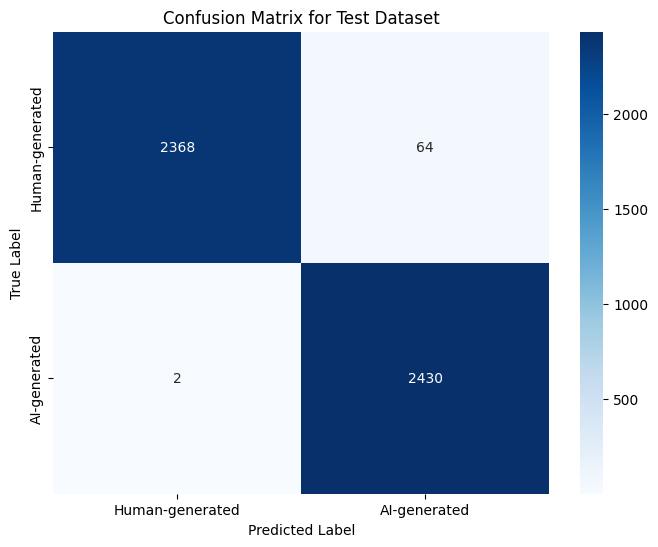

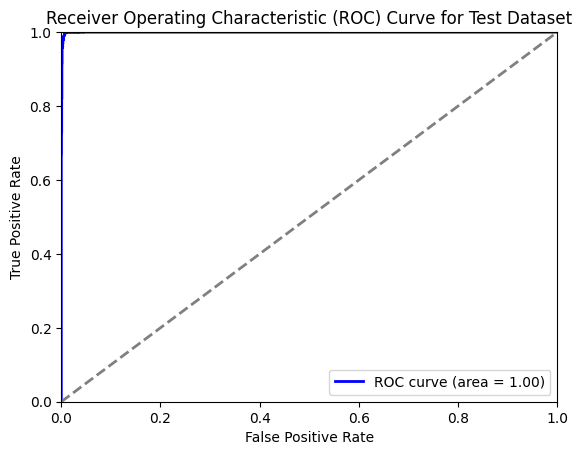

Test AUC-ROC: 0.9995


In [ ]:
# Compute and plot confusion matrix
conf_matrix_test = confusion_matrix(test_true, test_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Blues', xticklabels=['Human-generated', 'AI-generated'], yticklabels=['Human-generated', 'AI-generated'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Test Dataset')
plt.show()

# Calculate and plot AUC-ROC curve
test_auc = roc_auc_score(test_true, test_probs)
fpr, tpr, thresholds = roc_curve(test_true, test_probs)

plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % test_auc)
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Test Dataset')
plt.legend(loc="lower right")
plt.show()

print(f'Test AUC-ROC: {test_auc:.4f}')